# Imports

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Conexao com o Banco

In [2]:
con = sqlite3.connect('../data/if.db')

# Questao 1

In [3]:
df_questao1 = pd.read_sql("""
 select 
    provider,
    count(Session_ID) as count_session,
    sum(case when status='PROVIDER_FAILED' then 1 else 0 end) as sum_failed_sessions,
    1.0* sum(case when status='PROVIDER_FAILED' then 1 else 0 end) / count(Session_ID) as indice_falha

from
    biometry_execution
group by 
    provider
"""
, con)


In [4]:
df_questao1

,Provider,count_session,sum_failed_sessions,indice_falha
0,A,497,40,0.080483
1,B,40,8,0.200000
2,C,9,3,0.333333


C:\Users\Thales\AppData\Local\Temp\ipykernel_12664\1706866554.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Provider', y='indice_falha', data=df_questao1, palette=custom_palette)
C:\Users\Thales\AppData\Local\Temp\ipykernel_12664\1706866554.py:3: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.barplot(x='Provider', y='indice_falha', data=df_questao1, palette=custom_palette)


Text(0, 0.5, 'Falha')

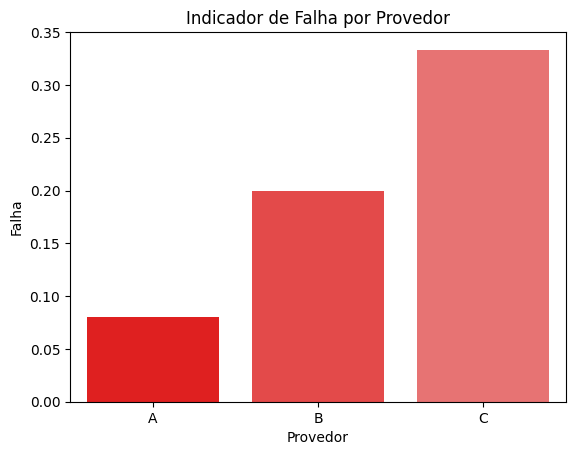

In [5]:
# Construcao do grafico de barras empilhado
custom_palette = sns.light_palette("red", reverse=True)
sns.barplot(x='Provider', y='indice_falha', data=df_questao1, palette=custom_palette)


plt.title('Indicador de Falha por Provedor')
plt.xlabel('Provedor')
plt.ylabel('Falha')



# Questao 2

In [6]:
df_questao2 = pd.read_sql("""
   select 
    d.Category,
    count(d.Driver_ID) as count_drivers

    from biometry as b
    left join drivers as d on b.Driver_ID = d.Driver_ID
    where status = 'NOT_MATCH'
    group by Category
    order by count(d.Driver_ID) desc

"""
, con)


In [7]:
df_questao2

,Category,count_drivers
0,Bronze,25
1,Prata,20
2,Iniciante,11
3,Ouro,4
4,Diamante,1


C:\Users\Thales\AppData\Local\Temp\ipykernel_12664\3594675175.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='count_drivers', data=df_questao2, palette=custom_palette)
C:\Users\Thales\AppData\Local\Temp\ipykernel_12664\3594675175.py:2: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(x='Category', y='count_drivers', data=df_questao2, palette=custom_palette)


Text(0, 0.5, 'Count of Fails')

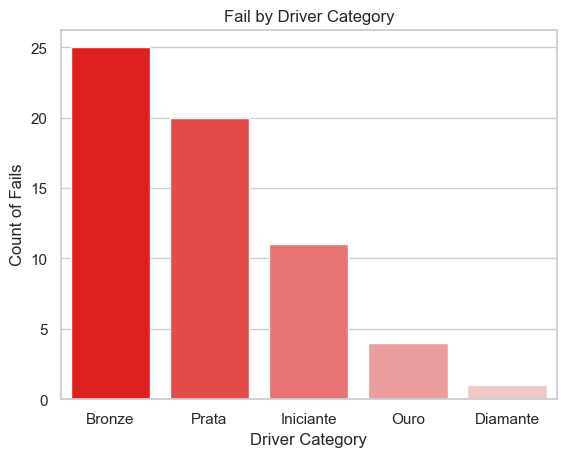

In [23]:
custom_palette = sns.light_palette("red", reverse=True)
sns.barplot(x='Category', y='count_drivers', data=df_questao2, palette=custom_palette)


plt.title('Fail by Driver Category')
plt.xlabel('Driver Category')
plt.ylabel('Count of Fails')


# Questao 3

In [31]:
df_questao3 = pd.read_sql("""
 WITH tb_similaridade_max AS (
    SELECT
        session_id,
        MAX(similarity) AS max_similaridade
    FROM
        biometry_execution
    GROUP BY
        session_id
),

-- Tabela que calcula a similaridade acima de 0.8

tb_similaridade_real AS (
    SELECT 
        COUNT(session_id) AS count_session_id,
        CASE 
            WHEN max_similaridade > 0.8 THEN 'match'
            WHEN max_similaridade IS NULL THEN 'provider_failed'
            ELSE 'not_match' 
        END AS status,
        'similaridade_real' AS similaridade_real
    FROM 
        tb_similaridade_max
    GROUP BY 
        CASE 
            WHEN max_similaridade > 0.8 THEN 'match'
            ELSE 'not_match' 
        END

),

-- Tabela que calcula o indice de match para sessoes com similaridade superior a 0.8

tb_indice_similaridade_real as (
    SELECT
        status,
        count_session_id,
        (select count(distinct Session_ID) from biometry_execution) as total_sessoes,
        1.0 * count_session_id /  (select count(distinct Session_ID) from biometry_execution) as indice_similaridade,
        'real_similarity' as description
        

    FROM 
        tb_similaridade_real
    GROUP BY
        status
),

-- Tabela que calcula a similaridade acima de 0.9

tb_similaridade_projetada AS (
    SELECT 
        COUNT(session_id) AS count_session_id,
        CASE 
            WHEN max_similaridade > 0.9 THEN 'match'
            WHEN max_similaridade IS NULL THEN 'provider_failed'
            ELSE 'not_match' 
        END AS status,
        'projetada' AS tipo
    FROM 
        tb_similaridade_max
    GROUP BY 
        CASE 
            WHEN max_similaridade > 0.9 THEN 'match'
            ELSE 'not_match' 
        END
),

-- Tabela que calcula o indice de match para sessoes com similaridade superior a 0.9

tb_indice_similaridade_projetada as (
    SELECT
        status,
        count_session_id,
        (select count(distinct Session_ID) from biometry_execution) as total_sessoes,
        1.0 * count_session_id /  (select count(distinct Session_ID) from biometry_execution) as indice_similaridade,
        'projected_similarity' as description
        

    FROM 
        tb_similaridade_projetada
    GROUP BY
        status
)

-- Tabela que faz a juncao da tabela de indice de match superior a 0.8 com a tabela de indice de match superior a 0.9

select * from tb_indice_similaridade_real

union

select * from tb_indice_similaridade_projetada 

"""
, con)


In [32]:
df_questao3

,status,count_session_id,total_sessoes,indice_similaridade,description
0,match,281,497,0.565392,projected_similarity
1,match,432,497,0.869215,real_similarity
2,not_match,65,497,0.130785,real_similarity
3,not_match,216,497,0.434608,projected_similarity


C:\Users\Thales\AppData\Local\Temp\ipykernel_12664\1863782891.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.histplot(df_questao3, x='description', hue='status',


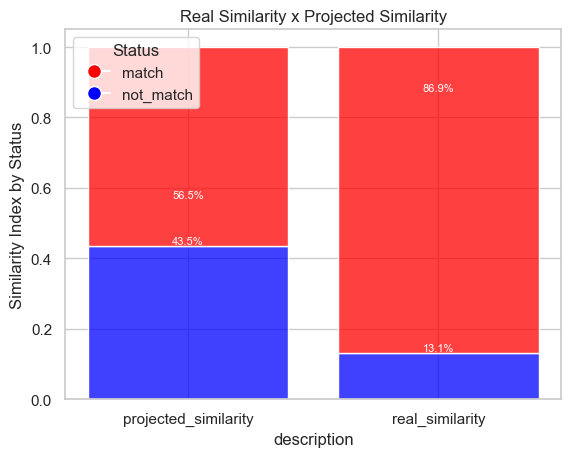

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

cores = ['red', 'blue', 'gray']
ax = sns.histplot(df_questao3, x='description', hue='status',
                  weights='indice_similaridade', multiple='stack',
                  palette=cores, shrink=0.8, stat='count')

ax.set_ylabel('Similarity Index by Status')
ax.set_title('Real Similarity x Projected Similarity')

custom_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='match'),
                 plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='not_match')]

ax.legend(handles=custom_legend, title='Status', loc='upper left')

for container in ax.containers:
    for p in container.patches:
        percentage_text = f"{p.get_height() * 100:.1f}%"
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(
            percentage_text,
            (x, y),
            ha='center',
            va='bottom',
            color='white',
            fontsize=8,
            xytext=(0, 0),
            textcoords='offset points',
        )

plt.show()


# Questao 4

In [35]:
df_questao4 = pd.read_sql("""

select 
    b.status,
    count(distinct(o.Order_ID)) as count_order,
    count(distinct(d.Driver_ID)) as count_drivers,
    1.0* count(distinct(o.Order_ID)) / count(distinct(d.Driver_ID)) as cancelled_orders_by_driver

from 
    orders as o
left join 
    drivers as d on o.Driver_ID = d.Driver_ID
left join 
    biometry as b on d.Driver_ID = b.Driver_ID

where 
    o.Order_Status = 'CANCELLED'
group by 
    b.status
order by 
    1.0* count(distinct(o.Order_ID)) / count(distinct(d.Driver_ID)) desc
"""
, con)


In [36]:
df_questao4

,Status,count_order,count_drivers,cancelled_orders_by_driver
0,NOT_MATCH,137,51,2.686275
1,MATCH,888,365,2.432877
2,None,412,175,2.354286
3,PROVIDER_FAILED,7,3,2.333333


C:\Users\Thales\AppData\Local\Temp\ipykernel_12664\383950281.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Status', y='cancelled_orders_by_driver', data=df_questao4, palette=custom_palette)
C:\Users\Thales\AppData\Local\Temp\ipykernel_12664\383950281.py:2: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.barplot(x='Status', y='cancelled_orders_by_driver', data=df_questao4, palette=custom_palette)


Text(0, 0.5, 'Number of Cancelled Orders by Driver')

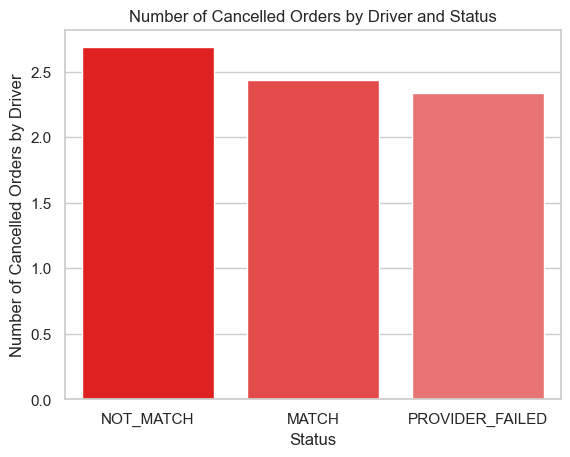

In [38]:
custom_palette = sns.light_palette("red", reverse=True)
sns.barplot(x='Status', y='cancelled_orders_by_driver', data=df_questao4, palette=custom_palette)


plt.title('Number of Cancelled Orders by Driver and Status')
plt.xlabel('Status')
plt.ylabel('Number of Cancelled Orders by Driver')

<Axes: >

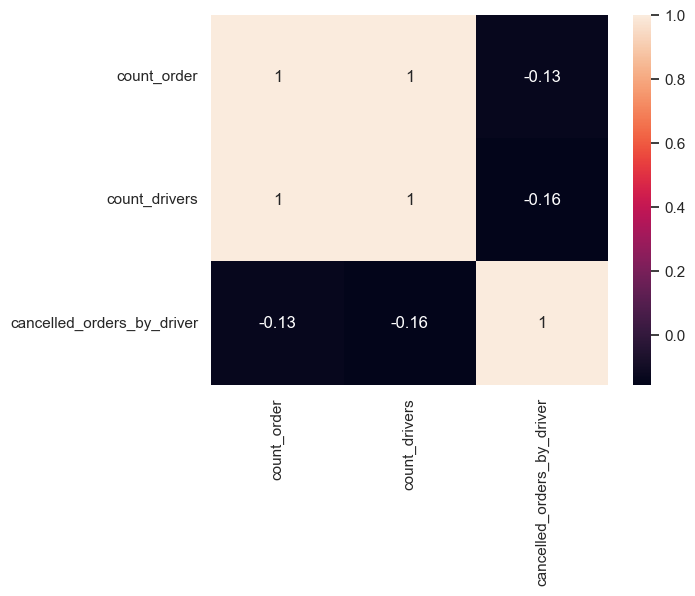

In [39]:
df_questao4_corr = df_questao4[['count_order','count_drivers','cancelled_orders_by_driver']]
sns.heatmap(df_questao4_corr.corr(method='pearson'),annot=True)

# Questao 5

In [18]:
df_questao5 = pd.read_sql("""


WITH tb_acesso_negados_por_dia AS (
    SELECT 
        Event_Dt,
        COUNT(Session_ID) AS acessos_negados
    FROM
        biometry_execution
    WHERE 
        status = 'NOT_MATCH'
    GROUP BY
        Event_Dt
),

-- Tabela que calcula a media de acessos negados 


tb_media_acessos_negados_por_dia AS (
    SELECT
        Event_Dt,
        acessos_negados,
        round(AVG(acessos_negados) OVER (),0) as media_acessos
    FROM 
        tb_acesso_negados_por_dia
)

SELECT 
    Event_Dt,
    acessos_negados,
    media_acessos
FROM 
    tb_media_acessos_negados_por_dia
ORDER BY 
    Event_Dt ASC;

"""
, con)


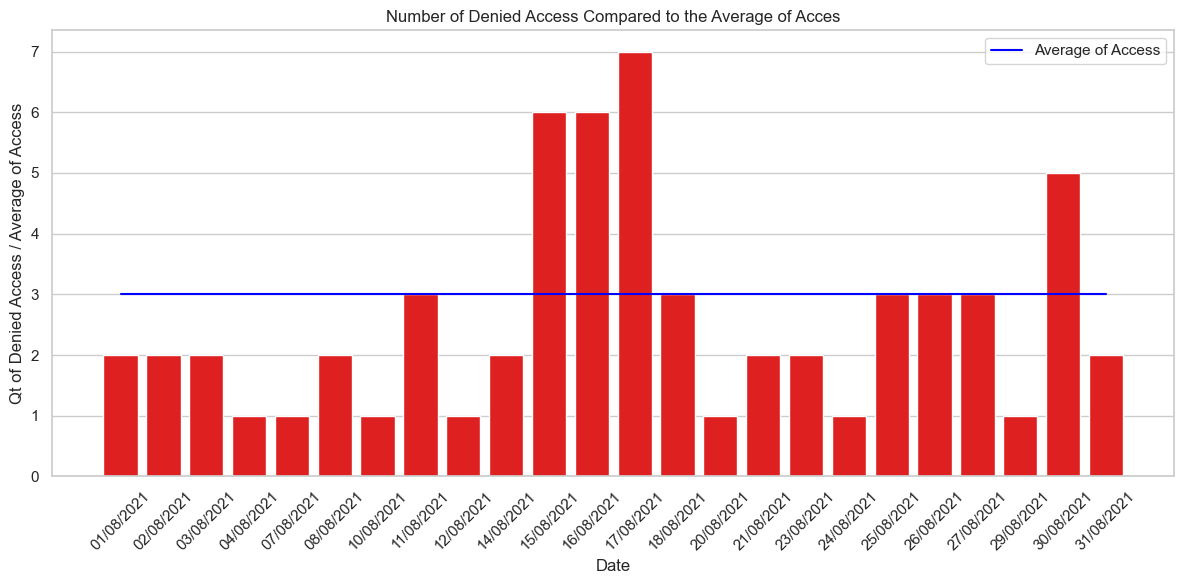

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

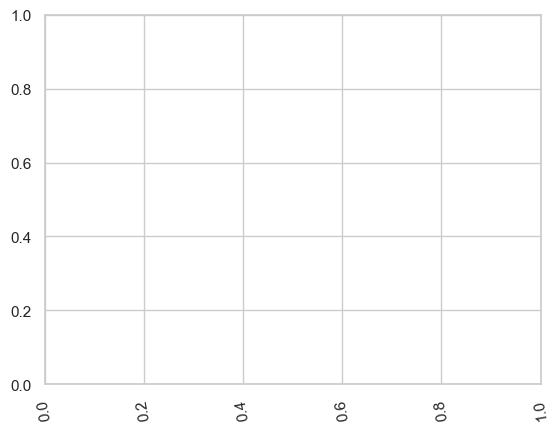

In [41]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x='Event_Dt', y='acessos_negados', data=df_questao5, color='red')
sns.lineplot(x='Event_Dt', y='media_acessos', data=df_questao5, color='blue', label='Average of Access')

plt.xticks(rotation=45)

plt.title('Number of Denied Access Compared to the Average of Acces')
plt.xlabel('Date')
plt.ylabel('Qt of Denied Access / Average of Access')

plt.legend()
plt.tight_layout()
plt.show()
plt.xticks(rotation=100)


# Questao 5.1

In [20]:
df_questao5_1 = pd.read_sql("""

select 
    b.Session_ID,
    b.Event_Dt,
    count(d.Driver_ID) as count_driver,
    d.register_dt,
    d.Category,
    d.Modal,
    avg(JULIANDAY(Event_Dt) - JULIANDAY(Register_Dt)) as dias_ativos
    

from 
    biometry b
left join 
    drivers d on b.Driver_ID = d.Driver_ID
where 
    1=1
    and Event_Dt in ('2021-08-15', '2021-08-16', '2021-08-17', '2021-08-30')
    and Status = 'NOT_MATCH'
group by 
    d.Category
order by
    count(d.Driver_ID) desc


"""
, con)


In [21]:
df_questao5_1

,Session_ID,Event_Dt,count_driver,Register_Dt,Category,Modal,dias_ativos
0,96298740,2021-08-15,9,2021-03-13,Prata,MOTO,480.777778
1,28973224,2021-08-15,8,2021-04-18,Bronze,MOTO,786.250000
2,10218881,2021-08-16,5,2018-05-15,Iniciante,MOTO,686.800000
3,73765347,2021-08-15,2,2020-02-08,Ouro,MOTO,792.000000


Text(0, 0.5, 'Número de Entregadores')

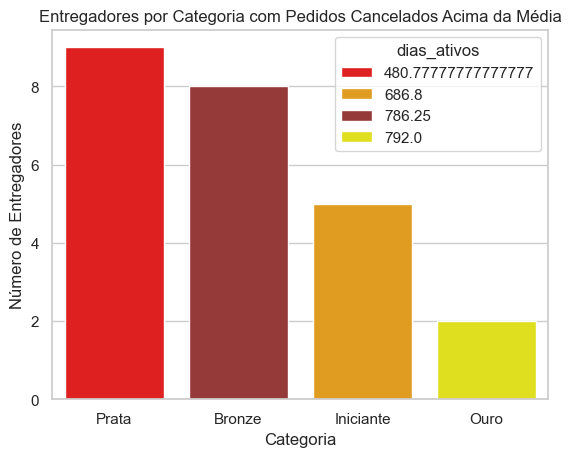

In [22]:
custom_palette = ['red','orange','brown','yellow']
sns.barplot(x='Category', y='count_driver', hue='dias_ativos', data=df_questao5_1, palette=custom_palette)


plt.title('Entregadores por Categoria com Pedidos Cancelados Acima da Média')
plt.xlabel('Categoria')
plt.ylabel('Número de Entregadores')